#### Methodology
- 1° Import airfoil profile from UIUC database
- 2° If necessary, adapt it to water conditions and to fit a hydrofoil profile (the database provides profiles adapted to aircraft and not hydrocrafts, meaning that some specificities will have to be readjusted). 
- 3° Generate a structured grid mesh of the profile
- 4° Create a Navier Stoke equations solver (this is the key computational physics problem for the project)
- 5° Compute velocity and pressure along the profile
- 6° Visualize their distributions
- 7° Compute lift and drag coefficients

In [3]:
# Import airfoil  
# Use NACA 63-412 AIRFOIL (n63412-il) source http://airfoiltools.com/airfoil/details?airfoil=n63412-il

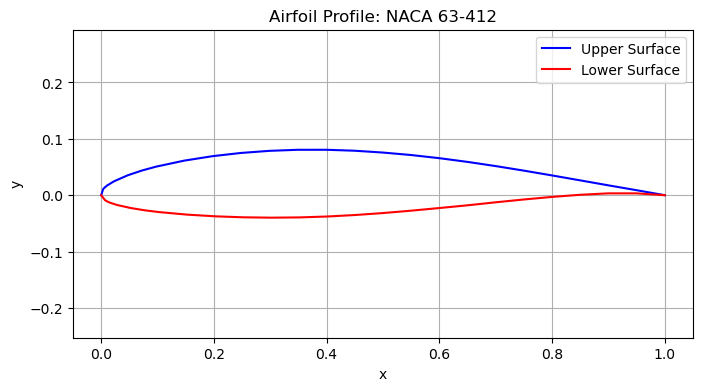

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Import the content manually
data = """
0.000000  0.000000
0.003360  0.010710
0.005670  0.013200
0.010410  0.017190
0.022570  0.024600
0.047270  0.035440
0.072180  0.043790
0.097180  0.050630
0.147350  0.061380
0.197650  0.069290
0.248000  0.074990
0.298400  0.078720
0.348820  0.080590
0.399240  0.080620
0.449640  0.078940
0.500000  0.075670
0.550310  0.071250
0.600570  0.065620
0.650760  0.058990
0.700870  0.051530
0.750890  0.043440
0.800840  0.034920
0.850700  0.026180
0.900490  0.017390
0.950230  0.008810
1.000000  0.000000

0.000000  0.000000
0.006640 -0.008710
0.009330 -0.010400
0.014590 -0.012910
0.027430 -0.017160
0.052730 -0.022800
0.077820 -0.026850
0.102820 -0.029950
0.152650 -0.034460
0.202350 -0.037450
0.252000 -0.039190
0.301600 -0.039840
0.351118 -0.039390
0.400760 -0.037780
0.450350 -0.035140
0.500000 -0.031640
0.549690 -0.027450
0.599430 -0.022780
0.649240 -0.017990
0.699130 -0.012650
0.749110 -0.007640
0.799160 -0.003080
0.849300  0.000740
0.899510  0.003290
0.949770  0.003300
1.000000  0.000000
"""


from io import StringIO
indata = np.loadtxt(StringIO(data))

# Split the data into upper and lower surfaces
split_index = np.where(indata[:, 0] == 1.0)[0][0]  # Find where x = 1 (trailing edge)
upper_surface = indata[:split_index + 1]
lower_surface = indata[split_index +1:]

# Plot the airfoil shape
plt.figure(figsize=(8, 4))
plt.plot(upper_surface[:, 0], upper_surface[:, 1], label='Upper Surface', color='b')
plt.plot(lower_surface[:, 0], lower_surface[:, 1], label='Lower Surface', color='r')
plt.title('Airfoil Profile: NACA 63-412')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

In [1]:
#Generate a mesh grid

(177674, 3)


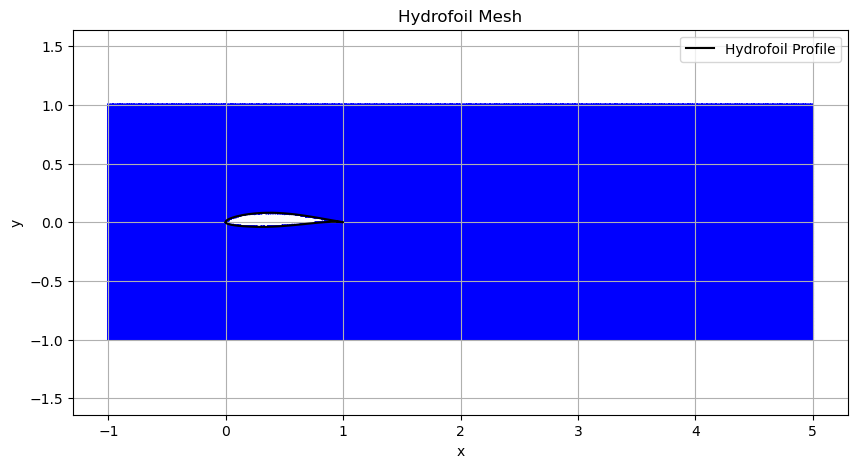

In [367]:
from scipy.spatial import Delaunay
from matplotlib.path import Path
# Combine surfaces to make the full airfoil boundary
airfoil_boundary = np.vstack([upper_surface, lower_surface[::-1]])

# Create the mesh grid around the airfoil
x_min, x_max = -1, 5  # Adjust domain around airfoil as needed
y_min, y_max = -1, 1
x_vals = np.linspace(x_min, x_max, 300) #Long computing time, change to much smaller numbers, I was just trying to see if my plotting problems were coming from the mesh size
y_vals = np.linspace(y_min, y_max, 300)
xx, yy = np.meshgrid(x_vals, y_vals)
points = np.vstack([xx.ravel(), yy.ravel()]).T

# Generate Delaunay triangulation
tri = Delaunay(points)

# Define the airfoil boundary path for point-in-polygon testing
airfoil_path = Path(airfoil_boundary)

# Filter triangles by checking if their centroids are inside the airfoil
def triangle_centroid(triangle):
    return np.mean(triangle, axis=0)

# Extract triangles' vertices from the Delaunay simplices
triangles = points[tri.simplices]
centroids = np.apply_along_axis(triangle_centroid, 1, triangles)

# Remove triangles whose centroids are inside the airfoil
outside_airfoil = ~airfoil_path.contains_points(centroids)
filtered_triangles = tri.simplices[outside_airfoil]
print(filtered_triangles.shape)

# Plotting the airfoil and the filtered mesh
plt.figure(figsize=(10, 5))
plt.plot(airfoil_boundary[:, 0], airfoil_boundary[:, 1], 'k-', label="Hydrofoil Profile")
plt.triplot(points[:, 0], points[:, 1], filtered_triangles, color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Hydrofoil Mesh")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
#Define a Navier Stokes equation solver 

In [49]:
#Water is considered as inviscid mu=0
# It is also incompressible λ = 0, 𝜌 = constant

Our Navier Stokes equation for momentum thus reduces to the Euler equations$$
\rho \frac{D\vec{V}}{Dt} = -\nabla p + \vec{F}$$


where:
$$\rho $$ is the fluid density
$$\frac{D\vec{V}}{Dt}$$ is the material derivative of the velocity field
$$-\nabla p$$ is the pressure gradient term
$$\vec{F}$$ is the body force per unit volume

I discretize the equations as per this paper, kardontchik_april16_2014_RG. (available as a pdf to download on research gate). See section 4. 2D tests on triangular meshes (structured and unstructured meshes) 
$$ U_{i, j}^{n+1}=U_{i, j}^{n}-\frac{\Delta t}{A_{i, j}} \sum_{s=1}^{N} L_{s} T_{s}^{-1} \hat{F}_{s} $$ 
where U is a matrix describing the state of the cell for each cell (so here triangle), with components rho, rho * u-component of velocity, rho * v-component of velocity and rho * E the total specific energy defined by E = e + speed**2/2., we sum the product across all edges of the cells of the length of an edge L, a rotation matrix T-1 and the Flux between the cell and its immediate neighbor to that edge. 

In [635]:
# Constants
rho_inf = 1.0          # Free-stream density
u_inf = 102.0          # Free-stream velocity in x-direction (in m/s), it's already much higher than a boat's speed but still relatively small (0.3M)
v_inf = 0.0            # Free-stream velocity in y-direction
p_inf = 101325.0       # Free-stream pressure (Pa)
gamma = 1.4            # Specific heat ratio (air)
R = 287.0              # Specific gas constant (air, J/(kg*K))
T_inf = 300.0          # Free-stream temperature (K)

e_inf = p_inf / ((gamma - 1) * rho_inf)  # Adjusted specific internal energy

# Initialize conserved variables for all triangles
num_triangles = len(filtered_triangles)
U = np.zeros((num_triangles, 4))  # Define matrix
U[:, 0] = rho_inf                 # rho
U[:, 1] = rho_inf * u_inf         # rho*u
U[:, 2] = rho_inf * v_inf         # rho*v (can be adjusted for variation)
U[:, 3] = rho_inf * (e_inf + 0.5 * (u_inf**2 + v_inf**2))  # rho*e
print(U.shape)

(177674, 4)


### Apply boundary conditions to U and apply U to my mesh 

In [371]:
print("Airfoil boundary shape:", airfoil_boundary.shape)
print("Points shape:", points.shape)
print("Triangles shape:", triangles.shape)

Airfoil boundary shape: (52, 2)
Points shape: (90000, 2)
Triangles shape: (178802, 3, 2)


In [637]:
def apply_boundary_conditions_mesh(U, airfoil_boundary, points, triangles):
    for i, node in enumerate(airfoil_boundary):
        distances = np.linalg.norm(points - node, axis=1)
        nearest_idx = np.argmin(distances)  # Find the closest mesh point
        # Get the previous and next point indices in the boundary (create an edge)
        prev_idx = i - 1 
        next_idx = i + 1

        # Get the points for the edges
        p1 = points[nearest_idx] 
        p2 = points[prev_idx] 
        p3 = points[next_idx] 

        # Compute vectors for the edges (p1 -> p2 and p1 -> p3)
        edge1 = p2 - p1
        edge2 = p3 - p1

        # Compute the normal vector (perpendicular to both edges)
        normal = np.array([-edge1[1], edge1[0]])  # 2D normal (perpendicular vector)
        normal /= np.linalg.norm(normal)  # Normalize the normal vector

        # Compute the normal velocity component (dot product of velocity and normal vector)
        u_n = U[nearest_idx, 1] * normal[0] + U[nearest_idx, 2] * normal[1]  # u_n = u * n_x + v * n_y

        # Enforce normal velocity to be zero (no flow through the boundary)
        U[nearest_idx, 1] -= u_n * normal[0]  # Remove normal component from u
        U[nearest_idx, 2] -= u_n * normal[1]  # Remove normal component from v
        
    return U
#Define U for the mesh
U_mesh = np.zeros((len(filtered_triangles), 4)) 
U_mesh[:, 0] = rho_inf  # Initialize density
U_mesh[:, 1:] = U[:len(filtered_triangles), 1:]  # Map initial conditions to mesh points

# Test
U_mesh = apply_boundary_conditions_mesh(U_mesh, airfoil_boundary, points, filtered_triangles)
print(U_mesh.shape)
print(U_mesh.shape[0])
print(U_mesh[:, 0].shape)

(177674, 4)
177674
(177674,)


### Define how to compute intermediate states and neighboring cells flux

In [639]:
def build_edge_to_triangle_mapping(triangles, points):
    """
    Edge-to-triangle mapping for a triangular mesh (useful to get and compute U left and U right in the flux calculations).
    Parameters: triangles (the indices of vertices that form each triangle, points)
    """
    edge_to_triangles = {}

    for i, tri in enumerate(triangles):
        # For each triangle, define its three edges
        for j in range(3):
            # Get the indices of the two vertices defining the edge
            v1, v2 = tri[j], tri[(j+1) % 3]
            
            # Sort the edge
            edge = tuple(sorted([v1, v2]))
            
            if edge not in edge_to_triangles:
                edge_to_triangles[edge] = []
            
            # Check if the edge is already associated with more than 2 triangles, Yes at first I had edges connected to 4 triangles...
            if len(edge_to_triangles[edge]) > 1:
                print(f"Warning: Edge {edge} is shared by more than two triangles!")
            
            # Add the triangle index to the edge's list
            edge_to_triangles[edge].append(i)
    
    return edge_to_triangles

In [759]:
def compute_flux_per_state(U_state, normal, gamma=1.4):
    """
    Compute the flux vector for a given conserved state and normal direction.
    
    Parameters: U_state (it's U), normal (it's the normal vector (nx, ny) to the edge)
    """
    rho = U_state[0]
    rho_u = U_state[1]
    rho_v = U_state[2]
    rho_e = U_state[3]

    u = rho_u / rho
    v = rho_v / rho
    velocity = np.array([u, v])
    v_n = np.dot(velocity, normal)  # Normal velocity
    p = (gamma - 1) * (rho_e - 0.5 * rho * (u**2 + v**2))  # Pressure
    # Flux vector
    flux = np.zeros(4)
    flux[0] = rho * v_n
    flux[1] = rho * u * v_n + p * normal[0]
    flux[2] = rho * v * v_n + p * normal[1]
    flux[3] = (rho_e + p) * v_n

    return flux

In [659]:
#Debugging, skip
#num_triangles = U_filtered.shape[0]
#print(f"Max index in filtered_triangles: {np.max(filtered_triangles)}")
#print(num_triangles)
print(U_mesh[1:].shape)

(177673, 4)


In [801]:
def compute_hllc_flux(U_left, U_right, normal, gamma):
    """
    Compute the HLLC flux across an edge.
    Parameters:
        U_left, U_right: Conserved variables on the left and right side of the edge.
        normal: Normal vector to the edge (2D).
        gamma: Ratio of specific heats.
    Returns:
        HLLC flux vector (4 components).
    """
    # Extract variables from left state
    rho_L = U_left[0]
    u_L = U_left[1]/rho_L
    v_L = U_left[2]/rho_L
    E_L = U_left[3]
    
    p_L = (gamma - 1) * (E_L - 0.5 * rho_L * (u_L**2 + v_L**2))
    u_n_L = u_L * normal[0] + v_L * normal[1]  # Normal velocity
    c_L = np.sqrt(gamma * p_L / rho_L)  # Speed of sound

    # Extract variables from right state
    rho_R = U_right[0]
    u_R = U_right[1] / rho_R
    v_R = U_right[2] / rho_R
    E_R = U_right[3]
    p_R = (gamma - 1) * (E_R - 0.5 * rho_R * (u_R**2 + v_R**2))
    u_n_R = u_R * normal[0] + v_R * normal[1]  # Normal velocity
    c_R = np.sqrt(gamma * p_R / rho_R)  # Speed of sound

    # Wave speeds
    S_L = np.minimum(u_n_L - c_L, u_n_R - c_R)
    S_R = np.maximum(u_n_L + c_L, u_n_R + c_R)
    S_star = (p_R - p_L + rho_L * u_n_L * (S_L - u_n_L) - rho_R * u_n_R * (S_R - u_n_R)) / (
        rho_L * (S_L - u_n_L) - rho_R * (S_R - u_n_R)
    )

    # Intermediate states
    rho_star_L = rho_L * (S_L - u_n_L) / (S_L - S_star)
    rho_star_R = rho_R * (S_R - u_n_R) / (S_R - S_star)

    E_star_L = (S_L - u_n_L) / (S_L - S_star) * (
        E_L + (S_star - u_n_L) * (S_star + p_L / (rho_L * (S_L - u_n_L)))
    )
    E_star_R = (S_R - u_n_R) / (S_R - S_star) * (
        E_R + (S_star - u_n_R) * (S_star + p_R / (rho_R * (S_R - u_n_R)))
    )

    # HLLC flux
    if np.all(S_L >= 0):
        hllcflux = compute_flux_per_state(U_left, normal, gamma)
    elif np.all(S_R <= 0):
        hllcflux = compute_flux_per_state(U_right, normal, gamma)
    else:
        if np.all(S_star > 0):  # If all elements in S_star are positive
            U_star_L = np.array([rho_star_L, rho_star_L * S_star * normal[0],
                                 rho_star_L * S_star * normal[1], E_star_L])
            hllcflux = compute_flux_per_state(U_left, normal, gamma) + S_L * (U_star_L - U_left)
        elif np.all(S_star <= 0):  # If all elements in S_star are negative
            U_star_R = np.array([rho_star_R, rho_star_R * S_star * normal[0],
                                 rho_star_R * S_star * normal[1], E_star_R])
            hllcflux = compute_flux_per_state(U_right, normal, gamma) + S_R * (U_star_R - U_right)
        else:
    # Handle the case where S_star might have mixed signs (contact wave case)
            U_star_L = np.array([rho_star_L, rho_star_L * S_star * normal[0],
                                 rho_star_L * S_star * normal[1], E_star_L])
            U_star_R = np.array([rho_star_R, rho_star_R * S_star * normal[0],
                                rho_star_R * S_star * normal[1], E_star_R])
            
            # Compute U_star as an interpolation between left and right states
            U_star = np.zeros_like(U_left)
            '''
            U_star = np.array ([0.5 * (rho_star_L + rho_star_R), 
                                S_star * normal[0] * 0.5 * (rho_star_L + rho_star_R), 
                                S_star * normal[1] * 0.5 * (rho_star_L + rho_star_R),
                               0.5 * (E_star_L + E_star_R)])
            print(U_star[1].shape)
            
            '''
            U_star = np.zeros_like(U_left)
            U_star[0] = 0.5 * (rho_star_L + rho_star_R)  # Density
            U_star[1] = S_star * normal[0] * U_star[0]   # x-momentum
            U_star[2] = S_star * normal[1] * U_star[0]   # y-momentum
            U_star[3] = 0.5 * (E_star_L + E_star_R)      # Energy
            #rho_star = 0.5 * (rho_star_L + rho_star_R)  # Simple average or other interpolation method
            #u_star = S_star * normal[0]
            #v_star = S_star * normal[1]
            #u_star = 0.5 * (rho_star_L * u_L * normal[0] + rho_star_R * u_R * normal[0])  # Example interpolation
            #v_star = 0.5 * (rho_star_L * v_L * normal[1] + rho_star_R * v_R * normal[1])
            #E_star = 0.5 * (E_star_L + E_star_R)
            #U_star = np.zeros_like(U_left)  # Ensure U_star has the same shape as U_left
            #U_star[0] = rho_star                   # Density
            #U_star[1] = rho_star * u_star          # x-momentum
            #U_star[2] = rho_star * v_star          # y-momentum
            #U_star[3] = E_star 
            #U_star = np.array([rho_star, rho_star * u_star * normal[0], rho_star * v_star * normal[1], E_star])

            hllcflux = compute_flux_per_state(U_star, normal, gamma)  # Use middle state flux
    return hllcflux

### Getting all the "finalized parameters" for the computation + computing U function

In [803]:
def compute_flux(U, points, edges, triangles, gamma=1.4):
    """
    Compute fluxes in the x and y directlion across edges for updating U.
    Parameters: U, points, edges, triangles
    """
    # Initialize flux arrays
    num_triangles = U.shape[0]
    LFT = np.zeros((num_triangles, 4))
    
    edge_to_triangles=build_edge_to_triangle_mapping(triangles, points)
    # Loop over edges
    for edge, connected_triangles in edge_to_triangles.items():
        if any(tri_idx >= num_triangles for tri_idx in connected_triangles):
            print(f"Warning: Out-of-bounds triangle index in connected_triangles: {connected_triangles}")
            continue  
        # Get points of the edge
        p1, p2 = points[edge[0]], points[edge[1]]
        edge_vector = p2 - p1
        edge_length = np.linalg.norm(edge_vector)
        normal = np.array([edge_vector[1], -edge_vector[0]]) / edge_length  # normal vector
        theta = np.arctan2(edge_vector[1], edge_vector[0])
        # Get triangles sharing the edge
        tri_left = connected_triangles[0]
        U_left = U[tri_left]
        if len(connected_triangles) == 2:
            # Internal edge: two triangles share the edge
            tri_right = connected_triangles[1]
            U_right = U[tri_right]
        else:
            # Boundary edge:
            U_right = np.copy(U_left)
            rho = U_left[0]  # Density
            u = U_left[1] / rho  # x-velocity
            v = U_left[2] / rho  # y-velocity
    
            # Compute the normal velocity component
            u_normal = u * normal[0] + v * normal[1]  # Dot product with normal vector
    
            # Adjust velocity to enforce no-penetration condition
            u_tangential = normal - u_normal * normal
    
            # Update U_right with the adjusted velocity
            U_right[1] = rho * u_tangential[0]  # Adjust rho*u
            U_right[2] = rho * u_tangential[1]  # Adjust rho*v
        #print(f"U_right: {U_right}")
        # Compute fluxes for the edge
        flux_L = compute_flux_per_state(U_left, normal, gamma)
        flux_R = compute_flux_per_state(U_right, normal, gamma)
        flux =  compute_hllc_flux(U_left, U_right, normal, gamma)
        T_inv = np.array(([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ]))
        flux_global = T_inv @ flux
        # Distribute flux contributions to connected triangles
        LFT[tri_left] += flux_global * edge_length

        if len(connected_triangles) == 2:
            # Add flux contributions to the right triangle
            LFT[tri_right] -= flux_global * edge_length
          

    return LFT
#compute_flux(U_mesh, points, edges, filtered_triangles, gamma=1.4)

In [729]:
def compute_triangle_areas(points, triangles):
    """
    Compute the areas of triangles.

    Parameters:
        points: ndarray of shape (num_points, 2)
            Coordinates of mesh points.
        triangles: ndarray of shape (num_triangles, 3)
            Indices of points forming each triangle.
    
    Returns:
        areas: ndarray of shape (num_triangles,)
            Area of each triangle.
    """
    areas = np.zeros(len(triangles))
    for i, triangle in enumerate(triangles):
        p1, p2, p3 = points[triangle]
        areas[i] = 0.5 * abs(
            p1[0] * (p2[1] - p3[1]) +
            p2[0] * (p3[1] - p1[1]) +
            p3[0] * (p1[1] - p2[1])
        )
    return areas

# Compute areas
A = compute_triangle_areas(points, filtered_triangles)

In [706]:
def updateU(U, LFT, dt, A):
    """
    Update U based on fluxes and time step.
    Parameters: U, flux_x, flux_y, dt: is the time step size, A: area of each triangle (so that the code can be easily adapted to other types of meshes)
    """
    U = U - (dt / A[:, None]) * LFT
    return U

### Visualize initial field to make sure everything is correct

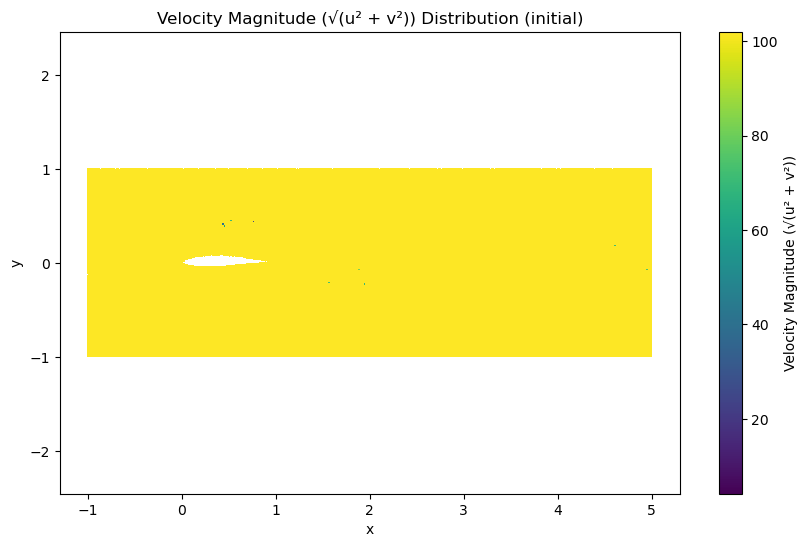

In [709]:
def visualize_field_direct(U, points, filtered_triangles, gamma=1.4, field="density"):
    """
    Parameters: U, points, filtered_triangles, field (is the field we want to visualize)
    """
    # Get variables
    rho = U[:, 0]
    rho_u = U[:, 1]
    rho_v = U[:, 2]
    rho_e = U[:, 3]

    # Compute quantities 
    u = rho_u / rho_inf
    v = rho_v / rho_inf
    velocity_magnitude = np.sqrt(u**2 + v**2)
    pressure = (gamma - 1) * (rho_e - 0.5 * rho * (u**2 + v**2))

    # Select field to visualize
    if field == "density":
        scalar_field = rho
        title = "Density (\u03C1)"
    elif field == "velocity":
        scalar_field = velocity_magnitude
        title = "Velocity Magnitude (\u221A(u\u00b2 + v\u00b2))"
    elif field == "pressure":
        scalar_field = pressure
        title = "Pressure (p)"
    else:
        raise ValueError("Invalid field. Choose 'density', 'velocity', or 'pressure'.")

    # Plot the field
    plt.figure(figsize=(10, 6))
    plt.tripcolor(points[:, 0], points[:, 1], filtered_triangles, scalar_field, shading="flat", cmap="viridis")
    plt.colorbar(label=title)
    plt.title(f"{title} Distribution (initial)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

# Test
visualize_field_direct(U_mesh, points, filtered_triangles, field="velocity")

### Finding dt

In [311]:
# Extract all unique edges and map them to triangles #Debugging
for edge, connected_triangles in edge_to_triangles.items():
    tri_left = connected_triangles[0]
    U_left = U[tri_left]
    tri_left = connected_triangles[0]
    if tri_left >= U.shape[0]:
        print(f"Invalid left triangle index {tri_left} for edge {edge}")
        continue

# For internal edges, check the right triangle
    if len(connected_triangles) == 2:
        tri_right = connected_triangles[1]
        if tri_right >= U.shape[0]:
            print(f"Invalid right triangle index {tri_right} for edge {edge}")
            continue

In [479]:
def find_neighbors(triangles):
    edge_dict = defaultdict(list)
    
    # Collect edges for each triangle
    for i, tri in enumerate(triangles):
        edges = [
            tuple(sorted([tri[0], tri[1]])),
            tuple(sorted([tri[1], tri[2]])),
            tuple(sorted([tri[2], tri[0]]))
        ]
        
        for edge in edges:
            edge_dict[edge].append(i)
    
    '''
    # Print the edges to see if they are shared
    for edge, triangles_with_edge in edge_dict.items():
        if len(triangles_with_edge) > 1:
            print(f"Edge {edge} is shared by triangles {triangles_with_edge}")
    '''
    # Set up the neighbor list
    neighbors = defaultdict(list)
    
    # If an edge is shared by exactly two triangles, add them as neighbors
    for edge, triangles_with_edge in edge_dict.items():
        if len(triangles_with_edge) == 2:  
            t1, t2 = triangles_with_edge
            neighbors[t1].append(t2)
            neighbors[t2].append(t1)
    
    return neighbors

In [481]:
neighbors = find_neighbors(filtered_triangles)

In [473]:
print(filtered_triangles.shape)
tri = filtered_triangles[0]
edges = [
    tuple(sorted([tri[0], tri[1]])), 
    tuple(sorted([tri[1], tri[2]])), 
    tuple(sorted([tri[2], tri[0]]))
]
print("Edges of first triangle:", edges)

(8181, 3)
Edges of first triangle: [(1700, 1801), (1800, 1801), (1700, 1800)]


In [229]:
def compute_edge_length(p1, p2):
    """Compute the length of an edge given two points."""
    return np.linalg.norm(p2 - p1)

def find_min_edge_length(triangles, points):
    """
    Find the minimum edge length in the triangular mesh.
    
    Parameters:
        triangles: ndarray of shape (num_triangles, 3)
            Indices of the points that form each triangle.
        points: ndarray of shape (num_points, 2)
            Coordinates of the mesh points.
    
    Returns:
        min_edge_length: float
            The smallest edge length.
    """
    min_edge_length = float('inf')  # Initialize with a large value
    
    # Loop through each triangle
    for tri in triangles:
        # Get the points corresponding to the triangle
        p1 = points[tri[0]]
        p2 = points[tri[1]]
        p3 = points[tri[2]]
        
        # Compute edge lengths
        edge_lengths = [
            compute_edge_length(p1, p2),
            compute_edge_length(p2, p3),
            compute_edge_length(p3, p1)
        ]
        
        # Update the minimum edge length
        min_edge_length = min(min_edge_length, *edge_lengths)
    
    return min_edge_length

# Example usage:
min_edge_length = find_min_edge_length(filtered_triangles, points)
print(f"Minimum edge length (Delta x): {min_edge_length}")


Minimum edge length (Delta x): 0.008163265306122436


In [231]:
dtcalc=min_edge_length/(1+2.28*10**8)
print(dtcalc)

3.58037950452572e-11


### Plotting and Computing the evolution of U

In [885]:
def plot_U_step(U, points, triangles, quantity="rho", step=0):
    """
    Plot a specified quantity from U on the mesh at a given step.
    Parameters: U, points, triangles, quantity: is the quantity to plot ('rho', 'u', 'v', 'e', 'pressure'). 
    step: is the current time step
    """
    quantity_map = {"rho": 0, "u": 1, "v": 2, "e": 3, "pressure": None}
    
    if quantity not in quantity_map:
        raise ValueError(f"Invalid quantity '{quantity}'. Choose from {list(quantity_map.keys())}.")
    if quantity == "pressure":
        u = U[:, 1] / rho_inf 
        v = U[:, 2] / rho_inf
        e = U[:,3]
        pressure = (gamma - 1) * (e - 0.5 * (u**2 + v**2))
        values = pressure
        
    else:
        idx = quantity_map[quantity]
        values = U[:, idx] 
    
    # Remap the triangles and points for visualization (otherwise you get an error because the shape of points is different from the shape of U)
    referenced_points = np.unique(triangles)
    point_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(referenced_points)}
    remapped_triangles = np.array([
        [point_mapping[vertex] for vertex in triangle]
        for triangle in triangles
    ])
    remapped_points = points[referenced_points]

    # Plot 
    plt.figure(figsize=(10,6))
    
    plt.tripcolor(
        remapped_points[:, 0], remapped_points[:, 1], remapped_triangles,
        facecolors=values, cmap="jet", vmin = np.percentile(values, 5), vmax = np.percentile(values, 95) #I use percentile especially because of the plot of the pressure)
    )

    #plt.colorbar.set_label(quantity)
    plt.colorbar(extend='both').set_label(quantity)
    plt.title(f"{quantity}")
    x_min, x_max = -1, 5
    y_min, y_max = -1, 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

0
Plotting step 0


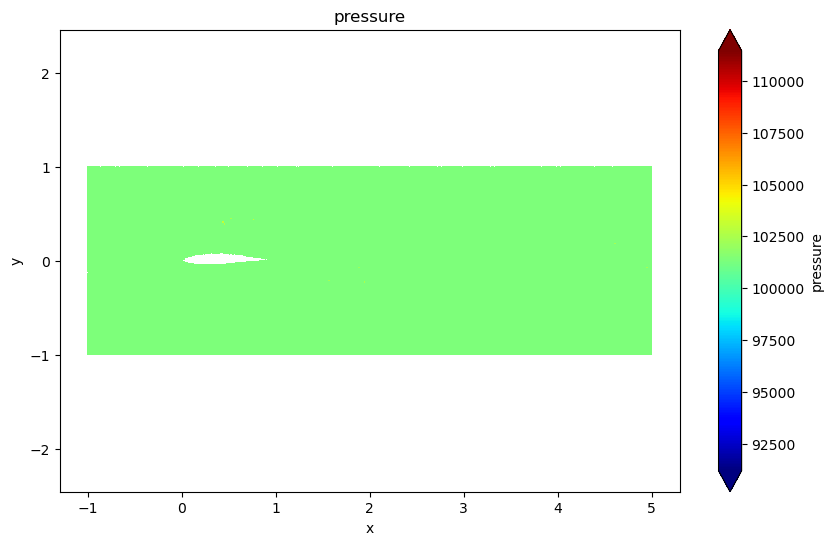

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Plotting step 25


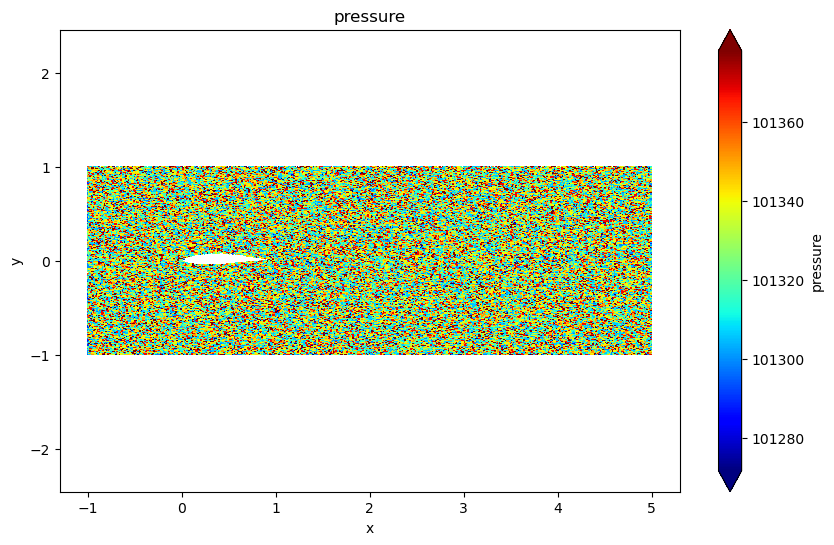

26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Plotting step 50


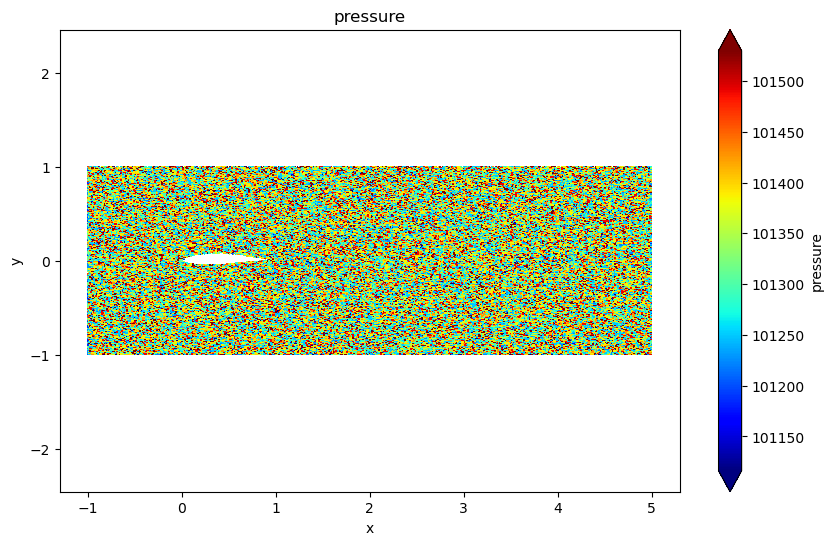

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
Plotting step 75


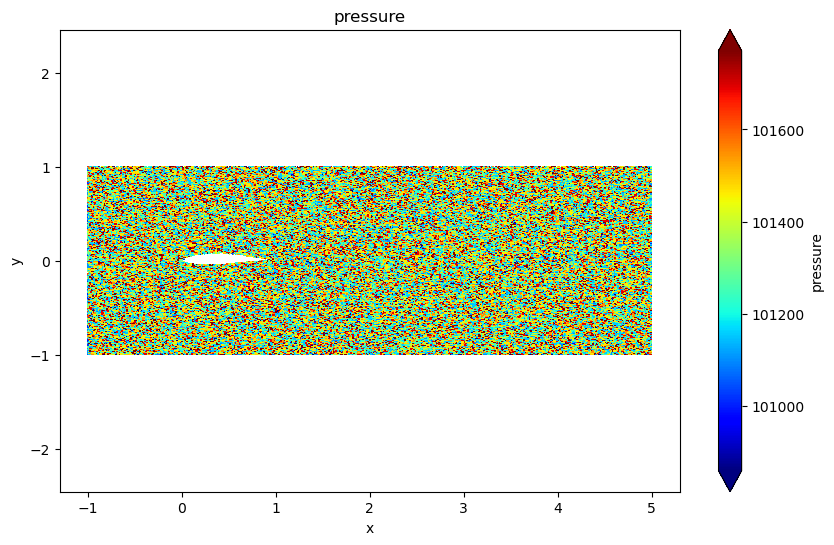

76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Plotting step 100


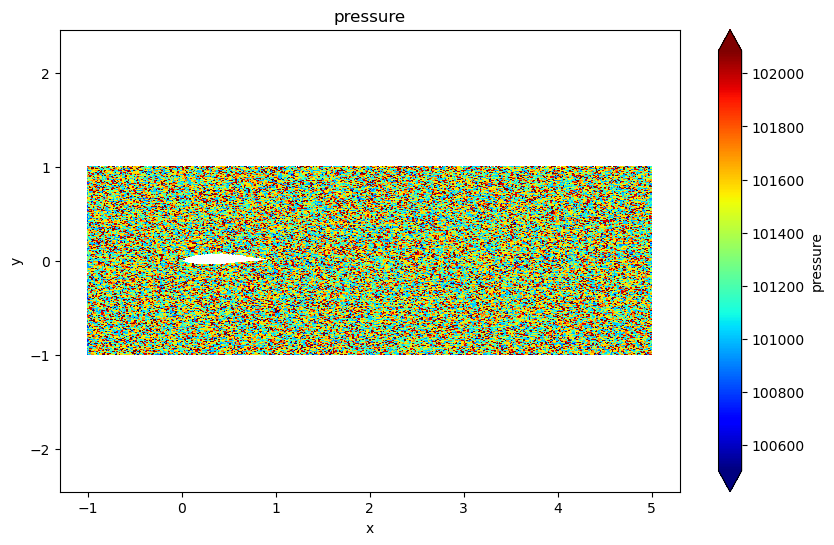

array([[ 9.96505087e-01,  9.88970524e+01,  6.85614624e+00,
         2.57260114e+05],
       [ 9.99889243e-01,  1.09262364e+02,  6.45402039e-02,
         2.58471735e+05],
       [ 9.96236367e-01,  1.09433062e+02,  6.82955076e+00,
         2.57158627e+05],
       ...,
       [ 1.00365133e+00,  9.46737090e+01, -6.85534825e+00,
         2.59834402e+05],
       [ 9.99693391e-01,  9.48771661e+01,  7.02887321e-03,
         2.58406201e+05],
       [ 1.00386868e+00,  1.09157914e+02, -6.91466696e+00,
         2.59903845e+05]])

In [891]:
def evolve_and_visualize(U, points, triangles, edges, A, max_steps, dt, plot_step, gamma=1.4):
    """
    Evolve U over time and visualize at certain steps.
    """
    for step in range(max_steps+1):
        print(step)
        LFT = compute_flux(U, points, edges, triangles, gamma=1.4)
        U = updateU(U, LFT, dt*step, A)
        # Plot
        if step % plot_step == 0:
            print(f"Plotting step {step}")
            plot_U_step(U, points, triangles, quantity="pressure", step=step)
    return U
    
nb_steps = 100
plot_step = 25
dt= 3.6*10**(-11) #Computation much below 
evolve_and_visualize(U_mesh, points, filtered_triangles, edges, A, nb_steps, dt, plot_step, gamma=1.4)

### Problem explanation
The problem is that I can see variations in the plot, but 1) I highly suspect they are not the ones I am supposed to see. I have attached a picture of a usual CFD pressure distribution plot for the same airfoil just a different angle of attack (which shouldn't impact the results THAT much). and 2) If they happen to be correct then I don't know how to plot them

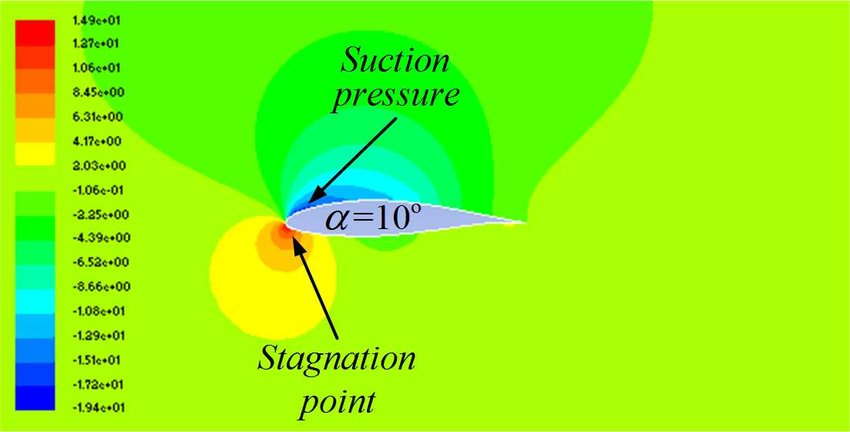

In [292]:
#Debugging because I was mapping my U incorrectly 
print(f"U.shape: {U.shape}")
print(f"Number of triangles: {len(filtered_triangles)}")
print(f"Number of edges: {len(edges)}")
print(f"Max index in edge_to_triangles: {max(max(v) for v in edge_to_triangles.values())}")

U.shape: (8181, 4)
Number of triangles: 8181
Number of edges: 12518
Max index in edge_to_triangles: 8180
